# Model Training/Selection/Evaluation

## Steps from instructions

Build 2 or 3 models and select the best one. <br>

### Imports and Loading Data Sets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
X_train = pd.read_csv('X_train.csv').drop('Unnamed: 0', axis=1)
X_test = pd.read_csv('X_test.csv').drop('Unnamed: 0', axis=1)
y_train = pd.read_csv('y_train.csv').drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('y_test.csv').drop('Unnamed: 0', axis=1)

### Pre-Model: PCA

(GMC) I'm going to first do a PCA, which may or may not be a good idea.

In [10]:
from sklearn.decomposition import PCA

In [14]:
X_train.shape

(25008, 63)

In [33]:
pca = PCA(n_components = 10)

In [34]:
pca.fit(X_train)

PCA(n_components=10)

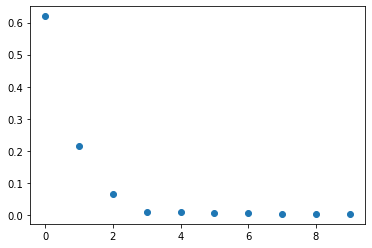

In [35]:
plt.scatter(x = np.arange(0,pca.n_components_), y = pca.explained_variance_ratio_)

(GMC) Two components does great. Three shold be good.
But, I have 5 labels. I think I want to have a minimum of 5 just in case?

Applying the transformation that was fitted on the training set to the training set and the test set:

In [127]:
NUMBER_COMPONENTS = 5

X_train_pca = pca.transform(X_train)
X_train_pca = pd.DataFrame({'PC'+str(i+1): X_train_pca[:,i] for i in range(0,NUMBER_COMPONENTS)})

X_test_pca = pca.transform(X_test)
X_test_pca = pd.DataFrame({'PC'+str(i+1): X_test_pca[:,i] for i in range(0,NUMBER_COMPONENTS)})

In [128]:
X_train_pca5.head()

,PC1,PC2,PC3,PC4,PC5
0,-4.869363,-3.118312,0.237245,0.301092,-0.726552
1,6.298538,5.766404,3.096097,-0.188415,0.120965
2,-1.915807,-5.135583,-2.803126,-0.005263,-0.498360
3,13.218232,5.683658,-1.998450,0.486553,1.853763
4,-3.738462,4.866961,3.223648,0.070555,-0.409274


In [129]:
NUMBER_COMPONENTS = 3

X_train_pca3 = pca.transform(X_train)
X_train_pca3 = pd.DataFrame({'PC'+str(i+1): X_train_pca3[:,i] for i in range(0,NUMBER_COMPONENTS)})

X_test_pca3 = pca.transform(X_test)
X_test_pca3 = pd.DataFrame({'PC'+str(i+1): X_test_pca3[:,i] for i in range(0,NUMBER_COMPONENTS)})

### Pre-model: Encoding Labels

I have roughly ordered them numerically proportional to severity, but the numbering is categorical. It's also easier to read than the long labels.

In [64]:
y_train.value_counts()

CrashSevr                  
C: Possible Injury             10306
B: Suspected Minor Injury       9159
O: No Injury                    2096
A: Suspected Serious Injury     1839
K: Killed                       1608
dtype: int64

In [101]:
"""
0, no injuries
1, possible injury
2, suspected minor injury
3, suspected serious injury
4, killed
"""

encoding = {'O': 0,
            'C': 1,
            'B': 2,
            'A': 3,
            'K': 4}

y_train = y_train.iloc[:,0].str[0]
y_train = y_train.map(encoding)

y_test = y_test.iloc[:,0].str[0]
y_test = y_test.map(encoding)

In [103]:
y_train.value_counts()

1    10306
2     9159
0     2096
3     1839
4     1608
Name: CrashSevr, dtype: int64

### First-Model: Random Forest

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [51]:
rfc = RandomForestClassifier()

In [159]:
# On data set as is
params = {'max_depth': np.arange(25,100,5),
          'min_samples_leaf': [1,2,3,5,8,13,21,34,55,89,144],
          'min_samples_split': np.arange(5,100)}
rscv_rfc = RandomizedSearchCV(estimator = rfc,
                          param_distributions=params,
                          n_iter = 50,
                          cv = 5
                         )

In [160]:
rscv_rfc.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]),
                                        'min_samples_leaf': [1, 2, 3, 5, 8, 13,
                                                             21, 34, 55, 89,
                                                             144],
                                        'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [161]:
results = pd.DataFrame(rscv_rfc.cv_results_)
results.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,0.976525,0.019521,0.061512,0.001380,93,1,50,"{'min_samples_split': 93, 'min_samples_leaf': ...",0.491403,0.488405,0.490204,0.487502,0.492501,0.490003,0.001847,1
25,0.966977,0.016590,0.063029,0.003978,58,5,70,"{'min_samples_split': 58, 'min_samples_leaf': ...",0.492803,0.489004,0.488605,0.483303,0.496101,0.489963,0.004309,2
1,0.967888,0.024296,0.061349,0.002511,67,8,25,"{'min_samples_split': 67, 'min_samples_leaf': ...",0.492603,0.492803,0.488804,0.483903,0.491302,0.489883,0.003312,3
17,0.958885,0.006851,0.060929,0.001369,74,2,55,"{'min_samples_split': 74, 'min_samples_leaf': ...",0.489604,0.492203,0.489404,0.483503,0.494101,0.489763,0.003581,4
33,0.980937,0.005983,0.063234,0.001981,72,1,90,"{'min_samples_split': 72, 'min_samples_leaf': ...",0.491803,0.490004,0.486206,0.485503,0.495101,0.489723,0.003564,5


In [162]:
# on PCA
rscv_rfc_pca = RandomizedSearchCV(estimator = rfc,
                          param_distributions=params,
                          n_iter = 50,
                          cv = 5
                         )

In [163]:
rscv_rfc_pca.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   param_distributions={'max_depth': array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]),
                                        'min_samples_leaf': [1, 2, 3, 5, 8, 13,
                                                             21, 34, 55, 89,
                                                             144],
                                        'min_samples_split': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [164]:
results = pd.DataFrame(rscv_pca.cv_results_)
results.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
40,2.231513,0.030816,0.048534,0.000502,55,95,"{'min_samples_leaf': 55, 'max_depth': 95}",0.449620,0.443822,0.458417,0.454109,0.455909,0.452375,0.005152,1
45,2.430394,0.164666,0.053499,0.006500,55,60,"{'min_samples_leaf': 55, 'max_depth': 60}",0.447421,0.445222,0.455018,0.453909,0.459108,0.452136,0.005101,2
25,1.837096,0.025568,0.041778,0.000336,144,45,"{'min_samples_leaf': 144, 'max_depth': 45}",0.449220,0.448021,0.452419,0.450510,0.455309,0.451096,0.002562,3
34,2.094321,0.009852,0.047009,0.001158,89,40,"{'min_samples_leaf': 89, 'max_depth': 40}",0.449020,0.451020,0.454418,0.450310,0.450510,0.451056,0.001806,4
32,2.286214,0.039668,0.049509,0.001856,55,45,"{'min_samples_leaf': 55, 'max_depth': 45}",0.447221,0.444422,0.455218,0.455909,0.452110,0.450976,0.004487,5


In [165]:
rfc_pred = rscv.predict(X_test)
pca_pred = rscv_pca.predict(X_test_pca)

In [135]:
from sklearn.metrics import classification_report

In [166]:
print(classification_report(y_test, rfc_pred))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       685
           1       0.53      0.68      0.60      3495
           2       0.44      0.55      0.49      2941
           3       0.00      0.00      0.00       635
           4       0.45      0.19      0.26       580

    accuracy                           0.49      8336
   macro avg       0.39      0.28      0.27      8336
weighted avg       0.45      0.49      0.44      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [167]:
print(classification_report(y_test, pca_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.50      0.63      0.56      3495
           2       0.38      0.49      0.43      2941
           3       0.00      0.00      0.00       635
           4       0.38      0.09      0.15       580

    accuracy                           0.45      8336
   macro avg       0.25      0.24      0.23      8336
weighted avg       0.37      0.45      0.40      8336



They're both really bad at identifying the no injuries and possible serious injuries. <br>
Getting any kind of "decent" score on 1 and 2 aren't very significant, since these classifications are the most represented!

### Second Model: KNN

In [141]:
from sklearn.neighbors import KNeighborsClassifier

In [142]:
knn = KNeighborsClassifier()

In [168]:
params = {'n_neighbors': np.arange(3,300)}
rscv_knn = RandomizedSearchCV(estimator = knn,
                             param_distributions = params,
                             n_iter = 25,
                             cv =5)

In [169]:
rscv_knn.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=25,
                   param_distributions={'n_neighbors': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85...
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 28

In [170]:
rscv_knn.best_params_

{'n_neighbors': 101}

In [176]:
results = pd.DataFrame(rscv_knn.cv_results_)
results.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
22,0.067173,0.003429,1.479035,0.011142,101,{'n_neighbors': 101},0.451619,0.450620,0.459016,0.454709,0.459708,0.455135,0.003712,1
21,0.068213,0.004455,1.545873,0.012051,121,{'n_neighbors': 121},0.452419,0.449620,0.454618,0.454509,0.461308,0.454495,0.003860,2
24,0.066522,0.004550,1.474236,0.017384,98,{'n_neighbors': 98},0.448421,0.448621,0.458617,0.454309,0.461508,0.454295,0.005242,3
5,0.078439,0.003957,1.815156,0.023080,95,{'n_neighbors': 95},0.451020,0.451220,0.459416,0.451110,0.458708,0.454295,0.003900,4
9,0.080622,0.005944,1.895146,0.076433,106,{'n_neighbors': 106},0.450220,0.448421,0.459216,0.455309,0.457109,0.454055,0.004099,5


In [171]:
knn_pred = rscv.predict(X_test)
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           0       0.50      0.00      0.01       685
           1       0.53      0.68      0.60      3495
           2       0.44      0.55      0.49      2941
           3       0.00      0.00      0.00       635
           4       0.45      0.19      0.26       580

    accuracy                           0.49      8336
   macro avg       0.39      0.28      0.27      8336
weighted avg       0.45      0.49      0.44      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [172]:
rscv_knn_pca = RandomizedSearchCV(estimator = knn,
                                 param_distributions = params,
                                 n_iter = 25,
                                 cv = 5)

In [173]:
rscv_knn_pca.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=25,
                   param_distributions={'n_neighbors': array([  3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85...
       211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223,
       224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236,
       237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262,
       263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275,
       276, 277, 278, 279, 280, 281, 282, 283, 28

In [174]:
rscv_knn_pca.best_params_

{'n_neighbors': 288}

In [177]:
knn_pca_pred = rscv_knn_pca.predict(X_test_pca)
print(classification_report(y_test, knn_pca_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.48      0.64      0.55      3495
           2       0.38      0.48      0.42      2941
           3       0.00      0.00      0.00       635
           4       0.00      0.00      0.00       580

    accuracy                           0.44      8336
   macro avg       0.17      0.22      0.19      8336
weighted avg       0.34      0.44      0.38      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Intermediate Asessment

All of these models are really struggling with classes 0 and 3 (and to an extent, 4), and these are the classes that are the least represented.

In [185]:
y_train.value_counts()/y_train.value_counts().sum()

1    0.412108
2    0.366243
0    0.083813
3    0.073536
4    0.064299
Name: CrashSevr, dtype: float64

Different models/tunings need to be explored.

In [186]:
from sklearn.svm import SVC

In [193]:
svc = SVC()

In [199]:
params = {'C': [0.01, 0.1, 1],
          'degree' : np.arange(3,5),
         }

In [200]:
from sklearn.model_selection import GridSearchCV

In [201]:
svc_model = GridSearchCV(estimator = svc,
                         param_grid = params,
                         cv = 5)

In [202]:
svc_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1], 'degree': array([3, 4])})

In [203]:
svc_model.best_params_

{'C': 1, 'degree': 3}

In [204]:
svc_pred = svc_model.predict(X_test)
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.54      0.63      0.58      3495
           2       0.42      0.62      0.50      2941
           3       0.00      0.00      0.00       635
           4       0.00      0.00      0.00       580

    accuracy                           0.48      8336
   macro avg       0.19      0.25      0.22      8336
weighted avg       0.38      0.48      0.42      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Going to try a larger set without (or less) cross validation.

In [211]:
svc0 = SVC(C=1.5)

In [212]:
svc0.fit(X_train, y_train)

SVC(C=1.5)

In [213]:
# SVC fitting is slow!
svc0_pred = svc0.predict(X_test)
print(classification_report(y_test, svc0_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.54      0.63      0.58      3495
           2       0.42      0.62      0.50      2941
           3       0.00      0.00      0.00       635
           4       0.00      0.00      0.00       580

    accuracy                           0.48      8336
   macro avg       0.19      0.25      0.22      8336
weighted avg       0.38      0.48      0.42      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Maybe I'll try logistic regression...

In [215]:
from sklearn.linear_model import LogisticRegression

In [218]:
# Going to basically try an out of the box trial first
logit = LogisticRegression(max_iter = 10**6)

In [219]:
logit.fit(X_train, y_train)

LogisticRegression(max_iter=1000000)

In [220]:
logit_pred = logit.predict(X_test)
print(classification_report(y_test, logit_pred))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00       685
           1       0.53      0.66      0.59      3495
           2       0.44      0.55      0.49      2941
           3       0.62      0.01      0.02       635
           4       0.45      0.29      0.36       580

    accuracy                           0.49      8336
   macro avg       0.46      0.30      0.29      8336
weighted avg       0.48      0.49      0.45      8336



In [222]:
pd.DataFrame(logit_pred).value_counts()

1    4333
2    3619
4     372
3       8
0       4
dtype: int64

In [223]:
pd.DataFrame(y_test).value_counts()

CrashSevr
1            3495
2            2941
0             685
3             635
4             580
dtype: int64

Already looks a bit better than other models! It's acutally predicting some of the more serious injuries.

In [262]:
logit = LogisticRegression(max_iter = 10**6)

In [263]:
params = {'C': np.arange(0.01,10,0.01)}

In [264]:
rscv_logit = RandomizedSearchCV(estimator = logit,
                                param_distributions = params,
                                n_iter = 25,
                                cv=3)

In [265]:
rscv_logit.fit(X_train, y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000000),
                   n_iter=25,
                   param_distributions={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])})

In [266]:
results = pd.DataFrame(rscv_logit.cv_results_)
results.sort_values(by='rank_test_score')[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
19,6.632151,0.641469,0.005863,0.002073,5.47,{'C': 5.47},0.490763,0.490283,0.489923,0.490323,0.000344,1
13,6.440988,1.014117,0.005980,0.002450,4.26,{'C': 4.26},0.490523,0.490523,0.489803,0.490283,0.000339,2
9,6.837015,0.737557,0.005821,0.001911,3.84,{'C': 3.84},0.490403,0.490523,0.489923,0.490283,0.000259,2
14,7.136296,0.365669,0.005451,0.002251,6.96,{'C': 6.96},0.490643,0.490643,0.489563,0.490283,0.000509,4
5,6.713712,0.331745,0.007124,0.002432,4.4,{'C': 4.3999999999999995},0.490283,0.490523,0.489923,0.490243,0.000246,5


In [271]:
results.sort_values(by='rank_test_score', ascending=False)[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
11,5.859365,0.246121,0.004437,0.000228,0.22,{'C': 0.22},0.489203,0.491003,0.489563,0.489923,0.000777,25
12,6.712310,0.276425,0.008814,0.000198,6.77,{'C': 6.77},0.490163,0.490163,0.489683,0.490003,0.000226,21
7,6.904558,0.619266,0.004507,0.000351,3.75,{'C': 3.75},0.490043,0.490043,0.489923,0.490003,0.000057,21
21,6.594241,0.798666,0.004411,0.000163,6.41,{'C': 6.41},0.490403,0.489923,0.489683,0.490003,0.000299,21
17,6.291880,0.452968,0.004439,0.000187,7.81,{'C': 7.81},0.490163,0.490283,0.489563,0.490003,0.000315,21


In [272]:
rscv_logit_pred = rscv_logit.predict(X_test)
print(classification_report(y_test, rscv_logit_pred))

              precision    recall  f1-score   support

           0       0.25      0.00      0.00       685
           1       0.53      0.66      0.59      3495
           2       0.44      0.55      0.49      2941
           3       0.71      0.01      0.02       635
           4       0.45      0.29      0.35       580

    accuracy                           0.49      8336
   macro avg       0.48      0.30      0.29      8336
weighted avg       0.49      0.49      0.45      8336



In [273]:
rscv_logit_pca = RandomizedSearchCV(estimator = logit,
                                param_distributions = params,
                                n_iter = 25,
                                cv=3)

In [274]:
rscv_logit_pca.fit(X_train_pca, y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000000),
                   n_iter=25,
                   param_distributions={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0...
       9.25, 9.26, 9.27, 9.28, 9.29, 9.3 , 9.31, 9.32, 9.33, 9.34, 9.35,
       9.36, 9.37, 9.38, 9.39, 9.4 , 9.41, 9.42, 9.43, 9.44, 9.45, 9.46,
       9.47, 9.48, 9.49, 9.5 , 9.51, 9.52, 9.53, 9.54, 9.55, 9.56, 9.57,
       9.58, 9.59, 9.6 , 9.61, 9.62, 9.63, 9.64, 9.65, 9.66, 9.67, 9.68,
       9.69, 9.7 , 9.71, 9.72, 9.73, 9.74, 9.75, 9.76, 9.77, 9.78, 9.79,
       9.8 , 9.81, 9.82, 9.83, 9.84, 9.85, 9.86, 9.87, 9.88, 9.89, 9.9 ,
       9.91, 9.92, 9.93, 9.94, 9.95, 9.96, 9.97, 9.98, 9.99])})

In [276]:
rscv_logit_pca_pred = rscv_logit_pca.predict(X_test_pca)
print(classification_report(y_test, rscv_logit_pca_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       685
           1       0.46      0.61      0.52      3495
           2       0.40      0.50      0.44      2941
           3       0.00      0.00      0.00       635
           4       0.00      0.00      0.00       580

    accuracy                           0.43      8336
   macro avg       0.17      0.22      0.19      8336
weighted avg       0.33      0.43      0.38      8336



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [278]:
from sklearn.ensemble import GradientBoostingClassifier

In [306]:
gbc = GradientBoostingClassifier(learning_rate=0.3, max_features=3, max_depth = 13)

In [307]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.3, max_depth=13, max_features=3)

In [308]:
gbc_pred = gbc.predict(X_test)
print(classification_report(y_test, gbc_pred))

              precision    recall  f1-score   support

           0       0.22      0.05      0.08       685
           1       0.50      0.60      0.55      3495
           2       0.41      0.49      0.45      2941
           3       0.23      0.06      0.09       635
           4       0.34      0.18      0.23       580

    accuracy                           0.45      8336
   macro avg       0.34      0.28      0.28      8336
weighted avg       0.41      0.45      0.42      8336



In [310]:
params = {'learning_rate': np.arange(0.01, 50, 0.01),
          'max_depth' : np.arange(3,12),
          'max_features' : np.arange(1,10)}

In [311]:
gbc = GradientBoostingClassifier()

In [312]:
rscv_gbc = RandomizedSearchCV(estimator = gbc,
                              param_distributions = params,
                              n_iter = 50,
                              cv=None)

In [313]:
rscv_gbc.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=50,
                   param_distributions={'learning_rate': array([1.000e-02, 2.000e-02, 3.000e-02, ..., 4.997e+01, 4.998e+01,
       4.999e+01]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'max_features': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [316]:
results = pd.DataFrame(rscv_gbc.cv_results_)
results.sort_values(by='rank_test_score')[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
15,4.605786,0.026804,0.048451,0.001511,9,5,0.43,"{'max_features': 9, 'max_depth': 5, 'learning_...",0.465414,0.467013,0.458617,0.464107,0.463707,0.463772,0.002825,1
28,3.657670,0.020401,0.048124,0.001831,5,5,0.63,"{'max_features': 5, 'max_depth': 5, 'learning_...",0.459416,0.466613,0.464214,0.455909,0.463107,0.461852,0.003770,2
37,6.783292,0.074825,0.095145,0.001707,2,9,3.87,"{'max_features': 2, 'max_depth': 9, 'learning_...",0.253898,0.244502,0.330668,0.353129,0.292741,0.294988,0.042180,3
36,6.335365,0.076743,0.090015,0.001569,4,8,3.51,"{'max_features': 4, 'max_depth': 8, 'learning_...",0.323071,0.299280,0.297681,0.324735,0.228354,0.294624,0.035039,4
14,4.758699,0.093122,0.076582,0.001985,1,8,28.52,"{'max_features': 1, 'max_depth': 8, 'learning_...",0.300880,0.296681,0.301879,0.247151,0.282943,0.285907,0.020524,5
3,14.012098,0.175708,0.134353,0.001955,9,10,40.27,"{'max_features': 9, 'max_depth': 10, 'learning...",0.291483,0.246501,0.311875,0.286943,0.286543,0.284669,0.021223,6
34,7.800388,0.082916,0.100793,0.000771,1,10,40.64,"{'max_features': 1, 'max_depth': 10, 'learning...",0.295882,0.289284,0.327669,0.282943,0.221356,0.283427,0.034641,7
5,12.970293,0.189954,0.126554,0.003492,7,10,1.39,"{'max_features': 7, 'max_depth': 10, 'learning...",0.279488,0.347461,0.271691,0.240752,0.274545,0.282787,0.035076,8
8,15.016180,0.087513,0.140083,0.001457,5,11,35.46,"{'max_features': 5, 'max_depth': 11, 'learning...",0.272491,0.276689,0.312675,0.257349,0.258348,0.275510,0.020080,9
21,4.600163,0.036129,0.075844,0.001256,3,7,13.22,"{'max_features': 3, 'max_depth': 7, 'learning_...",0.300480,0.255298,0.217713,0.320536,0.261348,0.271075,0.036061,10


In [314]:
rscv_gbc_pred = rscv_gbc.predict(X_test)
print(classification_report(y_test, rscv_gbc_pred))

              precision    recall  f1-score   support

           0       0.30      0.11      0.16       685
           1       0.54      0.64      0.58      3495
           2       0.45      0.51      0.48      2941
           3       0.15      0.04      0.06       635
           4       0.36      0.25      0.30       580

    accuracy                           0.48      8336
   macro avg       0.36      0.31      0.32      8336
weighted avg       0.44      0.48      0.45      8336



In [317]:
params = {'learning_rate': np.arange(0.01, 1, 0.01),
          'max_depth' : np.arange(3,25),
          'max_features' : np.arange(1,30)}

In [318]:
rscv_gbc2 = RandomizedSearchCV(estimator = gbc,
                               param_distributions = params,
                               n_iter = 50,
                               cv=None)

In [319]:
rscv_gbc2.fit(X_train, y_train)

RandomizedSearchCV(estimator=GradientBoostingClassifier(), n_iter=50,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0....
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24]),
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8

In [320]:
results = pd.DataFrame(rscv_gbc2.cv_results_)
results.sort_values(by='rank_test_score')[:10]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
45,5.921008,0.250281,0.038080,0.000441,16,4,0.13,"{'max_features': 16, 'max_depth': 4, 'learning...",0.492003,0.501200,0.490604,0.489302,0.499300,0.494482,0.004824,1
30,5.013527,0.358883,0.031337,0.002371,16,3,0.41,"{'max_features': 16, 'max_depth': 3, 'learning...",0.490604,0.491803,0.481607,0.479104,0.492501,0.487124,0.005616,2
40,13.347464,0.169076,0.087846,0.002423,21,8,0.06,"{'max_features': 21, 'max_depth': 8, 'learning...",0.488205,0.489804,0.482007,0.477504,0.489302,0.485365,0.004824,3
19,3.302324,0.151330,0.029730,0.000752,3,3,0.68,"{'max_features': 3, 'max_depth': 3, 'learning_...",0.486006,0.483207,0.479008,0.476305,0.493101,0.483525,0.005839,4
16,29.078526,0.427513,0.156783,0.000594,13,12,0.05,"{'max_features': 13, 'max_depth': 12, 'learnin...",0.484606,0.470012,0.473810,0.466507,0.476705,0.474328,0.006186,5
29,5.498966,0.335008,0.031339,0.002386,19,3,0.83,"{'max_features': 19, 'max_depth': 3, 'learning...",0.478009,0.478808,0.467213,0.471106,0.472106,0.473448,0.004375,6
1,6.274971,0.011682,0.059700,0.001473,12,6,0.25,"{'max_features': 12, 'max_depth': 6, 'learning...",0.472211,0.473810,0.468213,0.471506,0.475305,0.472209,0.002392,7
28,72.278270,0.146348,0.268699,0.002993,8,16,0.05,"{'max_features': 8, 'max_depth': 16, 'learning...",0.473011,0.463814,0.470612,0.455909,0.470706,0.466810,0.006259,8
0,35.045112,0.402043,0.180869,0.002299,8,13,0.1,"{'max_features': 8, 'max_depth': 13, 'learning...",0.463415,0.451419,0.467213,0.461308,0.464107,0.461492,0.005381,9
27,229.871425,4.282710,0.546594,0.011132,19,24,0.44,"{'max_features': 19, 'max_depth': 24, 'learnin...",0.469812,0.457817,0.457617,0.452310,0.465507,0.460612,0.006234,10


In [321]:
rscv_gbc2_pred = rscv_gbc2.predict(X_test)
print(classification_report(y_test, rscv_gbc2_pred))

              precision    recall  f1-score   support

           0       0.37      0.05      0.08       685
           1       0.54      0.66      0.60      3495
           2       0.45      0.55      0.49      2941
           3       0.38      0.01      0.02       635
           4       0.44      0.26      0.32       580

    accuracy                           0.49      8336
   macro avg       0.44      0.31      0.30      8336
weighted avg       0.47      0.49      0.46      8336



In [371]:
results.mean_fit_time.sum()//60

57.0

# Exploring Weighted Methods

In [379]:
from sklearn.metrics import confusion_matrix

In [418]:
weights = {0: 0.7,
           3: 1.5,
           4: 1.2,
           2: 0.2,
           1: 0.2}
logit = LogisticRegression(max_iter=10**6, class_weight = weights, multi_class = 'ovr')

In [419]:
logit.fit(X_train, y_train)

LogisticRegression(class_weight={0: 0.7, 1: 0.2, 2: 0.2, 3: 1.5, 4: 1.2},
                   max_iter=1000000, multi_class='ovr')

In [420]:
pred = logit.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.23      0.52      0.32       685
           1       0.58      0.36      0.44      3495
           2       0.51      0.09      0.15      2941
           3       0.11      0.56      0.19       635
           4       0.32      0.52      0.39       580

    accuracy                           0.30      8336
   macro avg       0.35      0.41      0.30      8336
weighted avg       0.47      0.30      0.31      8336



<AxesSubplot:>

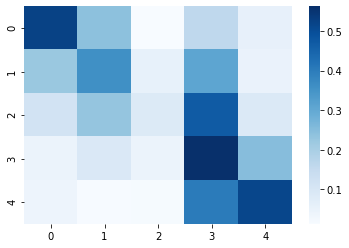

In [421]:
sns.heatmap(confusion_matrix(y_test, pred, normalize='true'), cmap='Blues')

### What this brief look at misclassification has shown me is my labels might be too fine grained. Stepping back and thinking has me wondering if it would be better to shrink the problem down to either a 2 or 3 class problem: Non-serious injuries vs Serious/Deadly Injuries.

In [456]:
minimal_mapping = {0:0,
                   1:0,
                   2:0,
                   3:1,
                   4:1}

y_train_ez = y_train.map(minimal_mapping)
y_test_ez = y_test.map(minimal_mapping)

In [457]:
y_train_ez.value_counts()

0    21561
1     3447
Name: CrashSevr, dtype: int64

In [479]:
logit = LogisticRegression(max_iter = 10**6, class_weight = 'balanced')

In [480]:
logit.fit(X_train, y_train_ez)

LogisticRegression(class_weight='balanced', max_iter=1000000)

In [481]:
pred = logit.predict(X_test)
print(classification_report(y_test_ez, pred))

              precision    recall  f1-score   support

           0       0.94      0.73      0.83      7121
           1       0.32      0.75      0.45      1215

    accuracy                           0.74      8336
   macro avg       0.63      0.74      0.64      8336
weighted avg       0.85      0.74      0.77      8336



In [441]:
mid_mapping = {0:0,
               1:0,
               2:0,
               3:1,
               4:2}
y_train_mid = y_train.map(mid_mapping)
y_test_mid = y_test.map(mid_mapping)

In [453]:
logit.fit(X_train, y_train_mid)

LogisticRegression(class_weight='balanced', max_iter=1000000)

In [454]:
pred = logit.predict(X_test)
print(classification_report(y_test_mid, pred))

              precision    recall  f1-score   support

           0       0.96      0.66      0.78      7121
           1       0.12      0.39      0.19       635
           2       0.27      0.67      0.39       580

    accuracy                           0.64      8336
   macro avg       0.45      0.57      0.45      8336
weighted avg       0.84      0.64      0.71      8336



<AxesSubplot:>

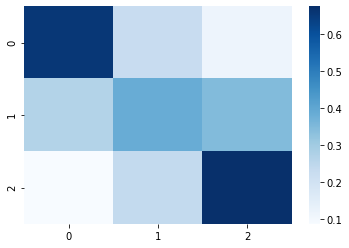

In [455]:
sns.heatmap(confusion_matrix(y_test_mid, pred, normalize='true'), cmap='Blues')

### Serious injuries are not very distinguishable from death.

In [496]:
def report(func, X_test, y_test):
    pred = func.predict(X_test)
    print(classification_report(y_test, pred))
    
def results(result, num=5):
    df = pd.DataFrame(result)
    return df.sort_values(by='rank_test_score')[:num]

In [486]:
rfc = RandomForestClassifier(class_weight = 'balanced')

In [559]:
params = {'max_depth': np.arange(15,100),
          'min_samples_leaf': np.arange(1,200),
          'min_samples_split': np.arange(2,200)}
rscv_rfc = RandomizedSearchCV(estimator = rfc,
                          param_distributions=params,
                          n_iter = 40,
                          cv = 3,
                          scoring='roc_auc'
                         )

In [560]:
rscv_rfc.fit(X_train, y_train_ez)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=40,
                   param_distributions={'max_depth': array([15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85, 86, 87...
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 191, 192, 1

In [776]:
report(rscv_rfc, X_train, y_train_ez)
report(rscv_rfc, X_test, y_test_ez)

              precision    recall  f1-score   support

           0       0.95      0.77      0.85     21561
           1       0.35      0.76      0.48      3447

    accuracy                           0.77     25008
   macro avg       0.65      0.77      0.67     25008
weighted avg       0.87      0.77      0.80     25008

              precision    recall  f1-score   support

           0       0.94      0.77      0.84      7121
           1       0.34      0.70      0.46      1215

    accuracy                           0.76      8336
   macro avg       0.64      0.73      0.65      8336
weighted avg       0.85      0.76      0.79      8336



In [562]:
results(rscv_rfc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
3,0.676241,0.003302,0.073416,0.000453,144,9,72,"{'min_samples_split': 144, 'min_samples_leaf':...",0.803657,0.807057,0.810206,0.806973,0.002674,1
39,0.697023,0.003487,0.075138,0.000503,117,7,64,"{'min_samples_split': 117, 'min_samples_leaf':...",0.803634,0.808003,0.808895,0.806844,0.002299,2
16,0.654870,0.003448,0.068827,0.000277,195,4,19,"{'min_samples_split': 195, 'min_samples_leaf':...",0.803445,0.808043,0.808869,0.806786,0.002386,3
28,0.651628,0.009900,0.078965,0.011792,150,25,19,"{'min_samples_split': 150, 'min_samples_leaf':...",0.800825,0.804680,0.807758,0.804421,0.002836,4
0,0.664418,0.021005,0.069105,0.000338,88,36,34,"{'min_samples_split': 88, 'min_samples_leaf': ...",0.799405,0.805336,0.806305,0.803682,0.003050,5


In [500]:
y_test_ez.value_counts()/y_test_ez.value_counts().sum()

0    0.854247
1    0.145753
Name: CrashSevr, dtype: float64

In [575]:
params = {'learning_rate': np.arange(0.01,1,0.01),
          'max_depth': np.arange(3,10),
          'min_samples_leaf': np.arange(1,10),
          'min_samples_split': np.arange(5,100,5)}
gbc = GradientBoostingClassifier()

In [576]:
# roc_auc scoring
rscv_gbc3 = RandomizedSearchCV(estimator = gbc,
                               param_distributions = params,
                               cv=3,
                               scoring = 'roc_auc',
                               n_iter = 20)

In [578]:
rscv_gbc3.fit(X_train, y_train_ez)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0....
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([ 5,

In [584]:
print('TRAIN')
report(rscv_gbc3, X_train, y_train_ez)
print('TEST')
report(rscv_gbc3, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     21561
           1       0.68      0.21      0.32      3447

    accuracy                           0.88     25008
   macro avg       0.78      0.60      0.63     25008
weighted avg       0.86      0.88      0.85     25008

TEST
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7121
           1       0.63      0.19      0.29      1215

    accuracy                           0.87      8336
   macro avg       0.75      0.59      0.61      8336
weighted avg       0.84      0.87      0.83      8336



In [580]:
# roc_auc_ovo
rscv_gbc4 = RandomizedSearchCV(estimator = gbc,
                               param_distributions = params,
                               cv=3,
                               scoring = 'roc_auc_ovo',
                               n_iter = 20)
rscv_gbc4.fit(X_train, y_train_ez)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0....
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       9

In [581]:
print('TRAIN')
report(rscv_gbc4, X_train, y_train_ez)
print('TEST')
report(rscv_gbc4, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     21561
           1       0.68      0.22      0.33      3447

    accuracy                           0.88     25008
   macro avg       0.78      0.60      0.63     25008
weighted avg       0.86      0.88      0.85     25008

TEST
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7121
           1       0.63      0.20      0.31      1215

    accuracy                           0.87      8336
   macro avg       0.75      0.59      0.62      8336
weighted avg       0.84      0.87      0.84      8336



In [665]:
params = {
          'max_depth': np.arange(3,12),
          'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,100,200]}
gbc = GradientBoostingClassifier(n_estimators = 500, learning_rate = 0.1, max_features=3)

In [666]:
# multi score
rscv_gbc5 = RandomizedSearchCV(estimator = gbc,
                               param_distributions = params,
                               cv=10,
                               scoring = ['roc_auc_ovo', 'recall'],
                               refit = 'recall',
                               n_iter = 5)

In [667]:
rscv_gbc5.fit(X_train, y_train_ez)

RandomizedSearchCV(cv=10,
                   estimator=GradientBoostingClassifier(max_features=3,
                                                        n_estimators=500),
                   n_iter=5,
                   param_distributions={'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 20,
                                                             30, 40, 50, 60, 70,
                                                             80, 90, 100, 200],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10, 20, 30,
                                                              40, 50, 60, 70,
                                                              80, 90, 100,
                                                              200]},


In [668]:
print('TRAIN')
report(rscv_gbc5, X_train, y_train_ez)
print('TEST')
report(rscv_gbc5, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.95      1.00      0.97     21561
           1       0.97      0.65      0.78      3447

    accuracy                           0.95     25008
   macro avg       0.96      0.83      0.88     25008
weighted avg       0.95      0.95      0.94     25008

TEST
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      7121
           1       0.53      0.24      0.33      1215

    accuracy                           0.86      8336
   macro avg       0.71      0.60      0.63      8336
weighted avg       0.83      0.86      0.83      8336



In [813]:
#pd.DataFrame(rscv_gbc5.cv_results_).sort_values(by='rank_test_roc_auc_ovo')[['mean_test_roc_auc_ovo','mean_test_recall']][-5:]
pd.DataFrame(rscv_gbc5.cv_results_).sort_values(by='rank_test_roc_auc_ovo', ascending=True)[-5:]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_roc_auc_ovo,split1_test_roc_auc_ovo,...,split3_test_recall,split4_test_recall,split5_test_recall,split6_test_recall,split7_test_recall,split8_test_recall,split9_test_recall,mean_test_recall,std_test_recall,rank_test_recall
2,2.491968,0.036754,0.046981,0.000489,70,4,5,"{'min_samples_split': 70, 'min_samples_leaf': ...",0.821814,0.808661,...,0.211594,0.202899,0.197101,0.228986,0.212209,0.223837,0.194767,0.204531,0.014927,5
0,3.022745,0.052012,0.057294,0.000934,7,8,6,"{'min_samples_split': 7, 'min_samples_leaf': 8...",0.815528,0.807100,...,0.214493,0.220290,0.200000,0.260870,0.232558,0.226744,0.215116,0.217297,0.019016,2
1,5.428678,0.033120,0.111734,0.005846,7,20,11,"{'min_samples_split': 7, 'min_samples_leaf': 2...",0.798139,0.785627,...,0.234783,0.200000,0.228986,0.240580,0.250000,0.235465,0.212209,0.224260,0.019106,1
3,9.445644,0.291724,0.129156,0.006824,9,2,11,"{'min_samples_split': 9, 'min_samples_leaf': 2...",0.781599,0.771746,...,0.231884,0.194203,0.226087,0.243478,0.226744,0.223837,0.194767,0.217289,0.017398,3
4,10.418106,0.304717,0.128582,0.001628,3,2,11,"{'min_samples_split': 3, 'min_samples_leaf': 2...",0.777020,0.772614,...,0.205797,0.188406,0.231884,0.211594,0.229651,0.191860,0.203488,0.208297,0.013221,4


In [774]:
gbc0 = GradientBoostingClassifier(n_estimators = 100, 
                                  learning_rate = 0.1, 
                                  max_features=8, 
                                  max_depth=3, 
                                  min_samples_leaf = 300)
gbc0.fit(X_train, y_train_ez)

GradientBoostingClassifier(max_features=8, min_samples_leaf=300)

In [775]:
print('TRAIN')
report(gbc0, X_train, y_train_ez)
print('TEST')
report(gbc0, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     21561
           1       0.64      0.14      0.23      3447

    accuracy                           0.87     25008
   macro avg       0.76      0.56      0.58     25008
weighted avg       0.85      0.87      0.83     25008

TEST
              precision    recall  f1-score   support

           0       0.87      0.99      0.92      7121
           1       0.62      0.14      0.23      1215

    accuracy                           0.86      8336
   macro avg       0.75      0.56      0.58      8336
weighted avg       0.83      0.86      0.82      8336



### RFC seems to do the best at balancing precision/recall/accuracy with resepect to class 1.

In [784]:
params = {'max_depth': [3,4,5,8],
          'min_samples_leaf': [1,2,3,5,10,50,100,300],
          'min_samples_split': [2,5,10,50,100,300]}
rscv_rfc0 = GridSearchCV(estimator = rfc,
                          param_grid=params,
                          cv = 6,
                          scoring='roc_auc'
                         )

In [778]:
rscv_rfc0.fit(X_train, y_train_ez)

GridSearchCV(cv=6, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [3, 4, 5, 8],
                         'min_samples_leaf': [1, 2, 3, 5, 10, 50, 100, 300],
                         'min_samples_split': [2, 5, 10, 50, 100, 300]},
             scoring='roc_auc')

In [779]:
print('TRAIN')
report(rscv_rfc0, X_train, y_train_ez)
print('TEST')
report(rscv_rfc0, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     21561
           1       0.33      0.72      0.45      3447

    accuracy                           0.76     25008
   macro avg       0.64      0.74      0.65     25008
weighted avg       0.86      0.76      0.79     25008

TEST
              precision    recall  f1-score   support

           0       0.94      0.77      0.84      7121
           1       0.34      0.71      0.46      1215

    accuracy                           0.76      8336
   macro avg       0.64      0.74      0.65      8336
weighted avg       0.85      0.76      0.79      8336



In [782]:
results(rscv_rfc0.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,mean_test_score,std_test_score,rank_test_score
147,0.633529,0.004852,0.032575,0.000328,8,1,50,"{'max_depth': 8, 'min_samples_leaf': 1, 'min_s...",0.811276,0.789854,0.807771,0.804383,0.809042,0.805288,0.804603,0.006980,1
154,0.652560,0.039481,0.032687,0.000703,8,2,100,"{'max_depth': 8, 'min_samples_leaf': 2, 'min_s...",0.810621,0.790384,0.808431,0.804149,0.806393,0.805743,0.804287,0.006547,2
171,0.636498,0.011745,0.034002,0.002286,8,10,50,"{'max_depth': 8, 'min_samples_leaf': 10, 'min_...",0.810376,0.788402,0.808710,0.805620,0.806905,0.804682,0.804116,0.007275,3
160,0.636294,0.003466,0.032941,0.000568,8,3,100,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...",0.811088,0.790100,0.807900,0.803256,0.805913,0.806312,0.804095,0.006685,4
170,0.636855,0.003122,0.033053,0.000441,8,10,10,"{'max_depth': 8, 'min_samples_leaf': 10, 'min_...",0.809995,0.791059,0.805545,0.805579,0.808122,0.803967,0.804044,0.006127,5


In [785]:
params = {'max_depth': [8,12,16,20],
          'min_samples_leaf': [1,2,3,5,10],
          'min_samples_split': [10,50,100,300]}
rscv_rfc1 = GridSearchCV(estimator = rfc,
                          param_grid=params,
                          cv = 4,
                          scoring='roc_auc'
                         )

In [786]:
rscv_rfc1.fit(X_train, y_train_ez)

GridSearchCV(cv=4, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'max_depth': [8, 12, 16, 20],
                         'min_samples_leaf': [1, 2, 3, 5, 10],
                         'min_samples_split': [10, 50, 100, 300]},
             scoring='roc_auc')

In [787]:
print('TRAIN')
report(rscv_rfc1, X_train, y_train_ez)
print('TEST')
report(rscv_rfc1, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     21561
           1       0.36      0.76      0.49      3447

    accuracy                           0.78     25008
   macro avg       0.66      0.77      0.67     25008
weighted avg       0.87      0.78      0.81     25008

TEST
              precision    recall  f1-score   support

           0       0.94      0.78      0.85      7121
           1       0.35      0.70      0.47      1215

    accuracy                           0.77      8336
   macro avg       0.65      0.74      0.66      8336
weighted avg       0.85      0.77      0.80      8336



In [788]:
results(rscv_rfc1.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
25,0.731719,0.004665,0.056322,0.000652,12,2,50,"{'max_depth': 12, 'min_samples_leaf': 2, 'min_...",0.806003,0.810483,0.813782,0.807049,0.809329,0.003059,1
62,0.817018,0.001709,0.062480,0.000216,20,1,100,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...",0.805232,0.810461,0.812993,0.807920,0.809152,0.002888,2
49,0.825371,0.005950,0.063951,0.000102,16,3,50,"{'max_depth': 16, 'min_samples_leaf': 3, 'min_...",0.806184,0.811346,0.813214,0.805420,0.809041,0.003317,3
42,0.800240,0.011955,0.059625,0.000564,16,1,100,"{'max_depth': 16, 'min_samples_leaf': 1, 'min_...",0.805206,0.811504,0.812031,0.806467,0.808802,0.003004,4
53,0.812168,0.007908,0.063539,0.000543,16,5,50,"{'max_depth': 16, 'min_samples_leaf': 5, 'min_...",0.806520,0.810658,0.812329,0.805439,0.808737,0.002845,5


In [804]:
params = {'n_estimators': [10, 100, 500, 1000, 2000, 10000],
          'max_depth': [3,5,8,13],
          'min_samples_leaf': [1,2,3,5,10,50],
          'min_samples_split': [10,50,100,300]}
rscv_rfc2 = RandomizedSearchCV(estimator = rfc,
                               param_distributions=params,
                               cv = 3,
                               scoring='roc_auc',
                               n_iter = 20
                               )

In [805]:
rscv_rfc2.fit(X_test, y_test_ez)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=20,
                   param_distributions={'max_depth': [3, 5, 8, 13],
                                        'min_samples_leaf': [1, 2, 3, 5, 10,
                                                             50],
                                        'min_samples_split': [10, 50, 100, 300],
                                        'n_estimators': [10, 100, 500, 1000,
                                                         2000, 10000]},
                   scoring='roc_auc')

In [806]:
results(rscv_rfc2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
8,24.657875,0.076621,2.447138,0.005491,10000,100,2,13,"{'n_estimators': 10000, 'min_samples_split': 1...",0.807030,0.815703,0.787879,0.803537,0.011624,1
16,0.227399,0.003028,0.027082,0.001455,100,100,1,8,"{'n_estimators': 100, 'min_samples_split': 100...",0.805207,0.814895,0.789634,0.803245,0.010405,2
12,0.246712,0.001088,0.027809,0.000696,100,100,5,13,"{'n_estimators': 100, 'min_samples_split': 100...",0.807117,0.814064,0.786906,0.802696,0.011519,3
5,4.661310,0.048387,0.458045,0.010312,2000,10,3,8,"{'n_estimators': 2000, 'min_samples_split': 10...",0.804872,0.814255,0.788439,0.802522,0.010670,4
18,2.336185,0.081099,0.230037,0.007449,1000,100,2,8,"{'n_estimators': 1000, 'min_samples_split': 10...",0.803988,0.814060,0.788693,0.802247,0.010429,5


In [807]:
print('TRAIN')
report(rscv_rfc2, X_train, y_train_ez)
print('TEST')
report(rscv_rfc2, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.94      0.77      0.85     21561
           1       0.33      0.69      0.44      3447

    accuracy                           0.76     25008
   macro avg       0.63      0.73      0.64     25008
weighted avg       0.85      0.76      0.79     25008

TEST
              precision    recall  f1-score   support

           0       0.95      0.79      0.86      7121
           1       0.38      0.76      0.50      1215

    accuracy                           0.78      8336
   macro avg       0.66      0.77      0.68      8336
weighted avg       0.87      0.78      0.81      8336



In [833]:
proba = rscv_rfc2.predict_proba(X_test)

In [844]:
thresshold = 0.32
pred = [int(x[1]>thresshold) for x in proba]

print(classification_report(y_test_ez, pred))

              precision    recall  f1-score   support

           0       0.98      0.51      0.67      7121
           1       0.25      0.95      0.39      1215

    accuracy                           0.57      8336
   macro avg       0.62      0.73      0.53      8336
weighted avg       0.88      0.57      0.63      8336



In [808]:
params = {'n_estimators': [10,100, 500, 1000, 2000],
          'max_depth': [3,5,8,13],
          'min_samples_leaf': [1,2,3,5,10],
          'min_samples_split': [10,50,100,300]
          }
gbc = GradientBoostingClassifier(learning_rate = 0.1)

In [809]:
rscv_gbc6 = RandomizedSearchCV(estimator = gbc,
                               param_distributions = params,
                               cv=3,
                               scoring = 'roc_auc',
                               n_iter=20)

In [810]:
rscv_gbc6.fit(X_train, y_train_ez)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'max_depth': [3, 5, 8, 13],
                                        'min_samples_leaf': [1, 2, 3, 5, 10],
                                        'min_samples_split': [10, 50, 100, 300],
                                        'n_estimators': [10, 100, 500, 1000,
                                                         2000]},
                   scoring='roc_auc')

In [811]:
results(rscv_gbc6.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
7,7.955773,0.019046,0.047244,0.001150,500,100,10,3,"{'n_estimators': 500, 'min_samples_split': 100...",0.809932,0.811762,0.815049,0.812248,0.002117,1
18,8.284203,0.057657,0.047323,0.000538,500,100,3,3,"{'n_estimators': 500, 'min_samples_split': 100...",0.810184,0.810721,0.813909,0.811605,0.001644,2
3,13.215332,0.095330,0.082762,0.020523,500,300,5,5,"{'n_estimators': 500, 'min_samples_split': 300...",0.797455,0.797451,0.802893,0.799266,0.002564,3
1,32.787465,0.249198,0.168767,0.002360,2000,300,3,3,"{'n_estimators': 2000, 'min_samples_split': 30...",0.794240,0.795180,0.800189,0.796536,0.002611,4
16,13.000347,0.130148,0.068924,0.001592,500,300,1,5,"{'n_estimators': 500, 'min_samples_split': 300...",0.793930,0.794530,0.801005,0.796488,0.003203,5


In [812]:
print('TRAIN')
report(rscv_gbc6, X_train, y_train_ez)
print('TEST')
report(rscv_gbc6, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.89      0.98      0.94     21561
           1       0.72      0.25      0.37      3447

    accuracy                           0.88     25008
   macro avg       0.80      0.62      0.65     25008
weighted avg       0.87      0.88      0.86     25008

TEST
              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7121
           1       0.61      0.22      0.32      1215

    accuracy                           0.87      8336
   macro avg       0.74      0.60      0.62      8336
weighted avg       0.84      0.87      0.84      8336



In [845]:
proba = rscv_gbc6.predict_proba(X_test)

In [858]:
thresshold = 0.04
pred = [int(x[1]>thresshold) for x in proba]

print(classification_report(y_test_ez, pred))

              precision    recall  f1-score   support

           0       0.98      0.36      0.53      7121
           1       0.20      0.95      0.33      1215

    accuracy                           0.45      8336
   macro avg       0.59      0.65      0.43      8336
weighted avg       0.86      0.45      0.50      8336



In [911]:
def custom_scorer(estimator, X_test, y_test):
    pred = estimator.predict(X_test)
    conf = confusion_matrix(y_test, pred, normalize='true')
    prec0 = conf[0][0]; rec0 = conf[0][1]; prec1 = conf[1][0]; rec1 = conf[1][1];

    return (4*rec1 + 2*prec1 + prec0**2 + rec0**2)

In [928]:
params = {'n_estimators': [10, 100, 500, 1000, 2000, 10000],
          'max_depth': [3,5,8,13],
          'min_samples_leaf': [1,2,3,5,10,50],
          'min_samples_split': [10,50,100,300]}
rscv_rfc3 = RandomizedSearchCV(estimator = rfc,
                               param_distributions=params,
                               cv = 3,
                               scoring = custom_scorer,
                               n_iter = 5
                               )

In [914]:
rscv_rfc3.fit(X_train, y_train_ez)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=5,
                   param_distributions={'max_depth': [3, 5, 8, 13],
                                        'min_samples_leaf': [1, 2, 3, 5, 10,
                                                             50],
                                        'min_samples_split': [10, 50, 100, 300],
                                        'n_estimators': [10, 100, 500, 1000,
                                                         2000, 10000]})

In [915]:
results(rscv_rfc3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,58.267608,0.261123,5.744412,0.009211,10000,300,1,13,"{'n_estimators': 10000, 'min_samples_split': 3...",0.744482,0.747601,0.743522,0.745202,0.001741,1
2,2.002170,0.011488,0.197944,0.000329,500,50,3,5,"{'n_estimators': 500, 'min_samples_split': 50,...",0.740283,0.744242,0.746281,0.743602,0.002490,2
3,9.641670,0.033044,0.957428,0.007733,2000,300,50,8,"{'n_estimators': 2000, 'min_samples_split': 30...",0.734885,0.740043,0.742083,0.739004,0.003029,3
0,0.069036,0.008858,0.008861,0.001023,10,100,5,5,"{'n_estimators': 10, 'min_samples_split': 100,...",0.748201,0.728527,0.728767,0.735165,0.009218,4
4,3.135869,0.023420,0.328234,0.000523,1000,300,2,3,"{'n_estimators': 1000, 'min_samples_split': 30...",0.732965,0.725408,0.733565,0.730646,0.003712,5


In [916]:
print('TRAIN')
report(rscv_rfc3, X_train, y_train_ez)
print('TEST')
report(rscv_rfc3, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.95      0.76      0.84     21561
           1       0.33      0.74      0.45      3447

    accuracy                           0.75     25008
   macro avg       0.64      0.75      0.65     25008
weighted avg       0.86      0.75      0.79     25008

TEST
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      7121
           1       0.34      0.73      0.46      1215

    accuracy                           0.75      8336
   macro avg       0.64      0.74      0.65      8336
weighted avg       0.85      0.75      0.78      8336



In [917]:
proba = rscv_rfc3.predict_proba(X_test)

In [925]:
thresshold = 0.27
pred = [int(x[1]>thresshold) for x in proba]

print(classification_report(y_test_ez, pred))

              precision    recall  f1-score   support

           0       0.98      0.35      0.52      7121
           1       0.20      0.95      0.33      1215

    accuracy                           0.44      8336
   macro avg       0.59      0.65      0.42      8336
weighted avg       0.86      0.44      0.49      8336



In [936]:
rscv_rfc2.best_params_

{'n_estimators': 10000,
 'min_samples_split': 100,
 'min_samples_leaf': 2,
 'max_depth': 13}

In [947]:
params = {'n_estimators': [10, 100, 500, 1000, 2000, 10000],
          'max_depth': [3,5,8,13],
          'min_samples_leaf': [1,2,3,5,10,50],
          'min_samples_split': [10,50,100,300]}
rscv_rfc20 = RandomizedSearchCV(estimator = rfc,
                                param_distributions=params,
                                cv = 3,
                                n_iter = 20
                                )

In [948]:
rscv_rfc20.fit(X_train, y_train_ez)

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=20,
                   param_distributions={'max_depth': [3, 5, 8, 13],
                                        'min_samples_leaf': [1, 2, 3, 5, 10,
                                                             50],
                                        'min_samples_split': [10, 50, 100, 300],
                                        'n_estimators': [10, 100, 500, 1000,
                                                         2000, 10000]})

In [949]:
results(rscv_rfc20.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
17,73.006374,0.333022,7.484511,0.058194,10000,10,1,13,"{'n_estimators': 10000, 'min_samples_split': 1...",0.796545,0.794386,0.794266,0.795066,0.001047,1
11,13.411498,0.068008,1.408130,0.056569,2000,50,10,13,"{'n_estimators': 2000, 'min_samples_split': 50...",0.767994,0.767514,0.766195,0.767234,0.000761,2
18,12.907444,0.036734,1.297778,0.000662,2000,100,5,13,"{'n_estimators': 2000, 'min_samples_split': 10...",0.761036,0.764155,0.760557,0.761916,0.001595,3
9,10.635613,0.102065,1.004823,0.004076,2000,10,10,8,"{'n_estimators': 2000, 'min_samples_split': 10...",0.751560,0.755758,0.754798,0.754039,0.001796,4
0,10.501747,0.096107,1.003391,0.009710,2000,50,10,8,"{'n_estimators': 2000, 'min_samples_split': 50...",0.750720,0.753959,0.754559,0.753079,0.001686,5


In [950]:
print('TRAIN')
report(rscv_rfc20, X_train, y_train_ez)
print('TEST')
report(rscv_rfc20, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.96      0.83      0.89     21561
           1       0.43      0.78      0.55      3447

    accuracy                           0.82     25008
   macro avg       0.69      0.80      0.72     25008
weighted avg       0.89      0.82      0.84     25008

TEST
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      7121
           1       0.38      0.64      0.47      1215

    accuracy                           0.79      8336
   macro avg       0.65      0.73      0.67      8336
weighted avg       0.85      0.79      0.81      8336



In [962]:
X_train2 = pd.read_csv('X_train.csv').drop('Unnamed: 0', axis=1)

In [963]:
params = {'n_estimators': [10,100, 500, 1000, 2000],
          'max_depth': [3,5,8,13],
          'min_samples_leaf': [1,2,3,5,10],
          'min_samples_split': [10,50,100,300]
          }
gbc = GradientBoostingClassifier(learning_rate = 0.1)
rscv_gbc20 = RandomizedSearchCV(estimator = gbc,
                                param_distributions = params,
                                cv=3,
                                n_iter=20)

In [964]:
rscv_gbc20.fit(X_train2, y_train_ez)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'max_depth': [3, 5, 8, 13],
                                        'min_samples_leaf': [1, 2, 3, 5, 10],
                                        'min_samples_split': [10, 50, 100, 300],
                                        'n_estimators': [10, 100, 500, 1000,
                                                         2000]})

In [965]:
results(rscv_gbc20.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,2.778048,0.028819,0.018037,0.001460,100,100,3,5,"{'n_estimators': 100, 'min_samples_split': 100...",0.866843,0.869842,0.871281,0.869322,0.001849,1
17,8.383273,0.088033,0.043881,0.000713,500,100,10,3,"{'n_estimators': 500, 'min_samples_split': 100...",0.867083,0.869962,0.870202,0.869082,0.001417,2
3,0.476006,0.025906,0.007616,0.000469,10,10,1,8,"{'n_estimators': 10, 'min_samples_split': 10, ...",0.863724,0.866123,0.865523,0.865123,0.001019,3
19,0.711587,0.007302,0.009206,0.001555,10,50,2,13,"{'n_estimators': 10, 'min_samples_split': 50, ...",0.865283,0.864563,0.865523,0.865123,0.000408,3
10,0.656781,0.015345,0.009058,0.000443,10,100,10,13,"{'n_estimators': 10, 'min_samples_split': 100,...",0.863724,0.865163,0.865643,0.864843,0.000816,5


In [966]:
print('TRAIN')
report(rscv_gbc20, X_train, y_train_ez)
print('TEST')
report(rscv_gbc20, X_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.89      0.99      0.93     21561
           1       0.72      0.22      0.33      3447

    accuracy                           0.88     25008
   macro avg       0.80      0.60      0.63     25008
weighted avg       0.86      0.88      0.85     25008

TEST
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7121
           1       0.59      0.18      0.27      1215

    accuracy                           0.86      8336
   macro avg       0.73      0.58      0.60      8336
weighted avg       0.83      0.86      0.83      8336



In [967]:
joblib.dump(rscv_gbc20.best_estimator_, 'rscv_gbc20_accuracy.pkl')

['rscv_gbc20_accuracy.pkl']

# The Best Recall Model

In [930]:
# Preferenced to increase recall on class 1 to 0.95
proba = rscv_rfc2.predict_proba(X_test)
thresshold = 0.32
pred = [int(x[1]>thresshold) for x in proba]

print(classification_report(y_test_ez, pred))

              precision    recall  f1-score   support

           0       0.98      0.51      0.67      7121
           1       0.25      0.95      0.39      1215

    accuracy                           0.57      8336
   macro avg       0.62      0.73      0.53      8336
weighted avg       0.88      0.57      0.63      8336



57% Overall Accuracy <br>
These is a 75% false positive rate on class 1, which is rather high. <br>
This is balanced by the high sensitivity (recall).

In [931]:
y_train_ez.to_csv('y_train_ez.csv')
y_test_ez.to_csv('y_test_ez.csv')

In [933]:
type(y_train)

pandas.core.series.Series

In [937]:
import joblib

In [938]:
rscv_rfc2.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=13,
                       min_samples_leaf=2, min_samples_split=100,
                       n_estimators=10000)

In [939]:
joblib.dump(rscv_rfc2.best_estimator_, 'rscv_rfc_best_estimator.pkl')

['rscv_rfc_best_estimator.pkl']

# Trying with some removed related features

In [974]:
X2_train = pd.read_csv('X2_train.csv')
X2_test = pd.read_csv('X2_test.csv')

In [972]:
params = {'n_estimators': [10,100, 500, 1000, 2000],
          'max_depth': [3,5,8,13],
          'min_samples_leaf': [1,2,3,5,10],
          'min_samples_split': [10,50,100,300]
          }
gbc = GradientBoostingClassifier(learning_rate = 0.1)
rscv_gbc30 = RandomizedSearchCV(estimator = gbc,
                                param_distributions = params,
                                cv=3,
                                n_iter=20)

In [973]:
rscv_gbc30.fit(X2_train, y_train_ez)

RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'max_depth': [3, 5, 8, 13],
                                        'min_samples_leaf': [1, 2, 3, 5, 10],
                                        'min_samples_split': [10, 50, 100, 300],
                                        'n_estimators': [10, 100, 500, 1000,
                                                         2000]})

In [976]:
print('TRAIN')
report(rscv_gbc30, X2_train, y_train_ez)
print('TEST')
report(rscv_gbc30, X2_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     21561
           1       0.66      0.15      0.25      3447

    accuracy                           0.87     25008
   macro avg       0.77      0.57      0.59     25008
weighted avg       0.85      0.87      0.84     25008

TEST
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      7121
           1       0.56      0.22      0.32      1215

    accuracy                           0.86      8336
   macro avg       0.72      0.60      0.62      8336
weighted avg       0.83      0.86      0.83      8336



In [978]:
joblib.dump(rscv_gbc30.best_estimator_, 'blind.pkl')

['blind.pkl']

In [999]:
blind = RandomForestClassifier(n_estimators = 1000,
                               min_samples_leaf = 1,
                               min_samples_split = 10,
                               class_weight = 'balanced',
                               max_depth = 13)
blind.fit(X2_train, y_train_ez)

RandomForestClassifier(class_weight='balanced', max_depth=13,
                       min_samples_split=10, n_estimators=1000)

In [1364]:
blind = GradientBoostingClassifier(n_estimators = 100,
                                   #min_samples_leaf = 10,
                                   #min_samples_split = 2,
                                   min_impurity_decrease = 0.3,
                                   max_depth = 7,
                                   learning_rate = 0.04,
                                   max_features=6,
                                   subsample = 0.3
                                   )
sample_weights = np.zeros(len(y_train_ez))
sample_weights[y_train_ez == 0] = 1
sample_weights[y_train_ez == 1] = 6.255

blind.fit(X2_train, y_train_ez, sample_weight = sample_weights)

GradientBoostingClassifier(learning_rate=0.04, max_depth=7, max_features=6,
                           min_impurity_decrease=0.3, subsample=0.3)

In [1365]:
print('TRAIN')
report(blind, X2_train, y_train_ez)
print('TEST')
report(blind, X2_test, y_test_ez)

TRAIN
              precision    recall  f1-score   support

           0       0.95      0.77      0.85     21561
           1       0.34      0.74      0.47      3447

    accuracy                           0.77     25008
   macro avg       0.64      0.75      0.66     25008
weighted avg       0.86      0.77      0.80     25008

TEST
              precision    recall  f1-score   support

           0       0.93      0.76      0.84      7121
           1       0.33      0.69      0.44      1215

    accuracy                           0.75      8336
   macro avg       0.63      0.72      0.64      8336
weighted avg       0.85      0.75      0.78      8336



In [1353]:
joblib.dump(blind, 'blind.pkl')

['blind.pkl']

In [1350]:
y_train_ez.value_counts()/min(y_train_ez.value_counts())

0    6.255004
1    1.000000
Name: CrashSevr, dtype: float64

In [1372]:
from sklearn import metrics

In [1450]:
params = {'learning_rate': [0.05, 0.1, 0.2],
          'n_estimators': [10, 100, 200],
          'max_depth': [3,5,7,13],
          'max_features': [3,5,8],
          'min_impurity_decrease': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
          'subsample': [0.05, 0.1, 0.25, 0.5]}

sample_weights = np.zeros(len(y_train_ez))
sample_weights[y_train_ez == 0] = 1
sample_weights[y_train_ez == 1] = 6.255

gbc = GradientBoostingClassifier()
blind2 = RandomizedSearchCV(estimator = gbc,
                            param_distributions = params,
                            n_iter = 20,
                            scoring = 'roc_auc_ovo_weighted',
                            cv=10)

In [1451]:
blind2.fit(X2_train, y_train_ez, sample_weight=sample_weights)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_iter=20,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 13],
                                        'max_features': [3, 5, 8],
                                        'min_impurity_decrease': [0.05, 0.1,
                                                                  0.2, 0.3, 0.4,
                                                                  0.5],
                                        'n_estimators': [10, 100, 200],
                                        'subsample': [0.05, 0.1, 0.25, 0.5]},
                   scoring='roc_auc_ovo_weighted')

In [1452]:
print(blind2.best_params_)
report(blind2, X2_train, y_train_ez)
report(blind2, X2_test, y_test_ez)

{'subsample': 0.5, 'n_estimators': 100, 'min_impurity_decrease': 0.05, 'max_features': 8, 'max_depth': 7, 'learning_rate': 0.05}
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     21561
           1       0.36      0.77      0.49      3447

    accuracy                           0.78     25008
   macro avg       0.65      0.77      0.67     25008
weighted avg       0.87      0.78      0.81     25008

              precision    recall  f1-score   support

           0       0.94      0.69      0.79      7121
           1       0.29      0.76      0.42      1215

    accuracy                           0.70      8336
   macro avg       0.62      0.72      0.61      8336
weighted avg       0.85      0.70      0.74      8336



In [1453]:
joblib.dump(blind2, 'blind.pkl')

['blind.pkl']

In [1440]:
metrics.f1_score(y_test_ez, blind2.predict(X2_test), average='macro')

0.622390462677589

In [1423]:
def custom_scorer(estimator, X_test, y_test):
    pred = estimator.predict(X_test)
    recall = metrics.recall_score(y_test, pred, average='macro')
    accuracy = mectrics.score(y_test, pred)
    return 2.5/(1.5*recall+accuracy)